# Pytorch Lightning Introduction

Welcome to the introduction to [`PyTorchLightning`](https://www.pytorchlightning.ai/). PyTorch Lightning is a wrapper for PyTorch that is focused towards building neural networks model quickly by removing the boilerplate code. It also extends the functionality of PyTorch, for example, with model Callbacks and automatic porting to GPU to accelerate computations.

Let's get started by installing PyTorch Lightning.

### Installing Pytorch Lightning

In [1]:
# # remove the "> /dev/null" if you want to see the output of installation status
# !pip install pytorch-lightning 

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import tensorboard

import pytorch_lightning as pl
print(f"Lightning version: {pl.__version__}")

Lightning version: 2.2.5


# 1. Idea behind PyTorch Lightning

Codes in a Deep learning project consists of three main categories:

1. **Research code**   
    This is the exciting part of the experiment where you configure the model architecture and try out different optimizers and target task. This is managed by the `LightningModule` of PyTorch Lightning.
    
2. **Engineering code**  
    This is the same set of code that remain the same for all deep learning projects.Recall the training block of previous notebooks where we loop through the epochs and mini-batches. The `Trainer` class of PyTorch Lightning takes care of this part of code.
    
3. **Non-essential code**
    It is very important that we log our training metrics and organize different training runs to have purposeful experimentation of models. The `Callbacks` class PyTorch Lightning helps us with this section. 

Let's look at each of these modules in detail.

1. **LightningModules** contain all model related code. This is the part where we are working on when creating a new project. The idea is to have all important code in one module, e.g., the model's architecture and the evaluation of training and validation metrics. This provides a better overview as repeated elements, such as the training procedure, are not stored in the code that we work on. The lightning module also handles the calls `.to(device)` or `.train()` and `.eval()`. Hence, there is no need anymore to switch between the cpu and gpu and to take care of the model's mode as this is automated by the LightningModule. The framework also enables easy parallel computation on multiple gpus. 

2. **Trainer** contains all code needed for training our neural networks that doesn't change for each project ("one size fits all"). Usually, we don't touch the code automated by this class. The arguments that are specific for one training such as learning rate and batch size are provided as initialization arguments for the LightningModule.

3. **Callbacks** automate all parts needed for logging hyperparameters or training results such as the tensorboard logger. Logging becomes very important for research later since the results of experiments need to be reproducible.

All in all, PyTorch is a framework that handles all (annoying) "engineering" stuff for you such that you have more time for exciting research and scientific coding. This also results in the advantage that automated parts are guaranteed to be bug-free. Hence, you can't include a bug in a part of your code that is often used but not often checked. 

# 2. Overview of the PyTorch Lightning code

Research relevant code goes into the `LightningModule`. The advantage is that we have all the model building, training & validation steps within a single class. These are the components that usually change based on the projects and tasks.

![tensorBoard Interface](./images/pl_quick_start_full_compressed.gif)

The remaining code is automated by the `Trainer` class which takes care of the 

---

tasks of our mechanical training loops components such as iterating through the minibatches and gradient updating steps.

![alt text](https://miro.medium.com/max/700/1*b81_j__xv8M0Bb6nFTXbAA.png)

We could already see how much more readable and concise our code is, after being transformed by PyTorch Lightning.

Let us now train a neural network model with PyTorch Lightning.

# 4. Training with PyTorch Lightning

We will build a two-layer neural network to train on the the [`Fashion-MNIST`](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) dataset for this notebook. 

## 4.1 Define A LightningModule

We define our network as an instance of `pl.LightningModule` which replaces our `PyTorch` network based on the class `nn.Module`. Additionally, it contains all the relevant parts that are used for training and evaluating different models on various tasks.  

Let's have a look at the implementation of `TwoLayerNet` in `dl_zero2one.lightning_models`.

The `__init__()` and `forward()` function defining the forward  pass remain the same. Hence, we can just copy the code from the `nn.Module`.

```python
class TwoLayerNet(pl.LightningModule):
    def __init__(self, hparams, input_size=1 * 28 * 28, hidden_size=512, num_classes=10):
        super().__init__()
        self.hparams = hparams

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        # flatten the image  before sending as input to the model
        N, _, _, _ = x.shape
        x = x.view(N, -1)

        x = self.model(x)

        return x
```

We will now define the training  and validation steps since they also vary with different tasks and projects. Consequently, it is useful to integrate these parts into our instance of `LightningModule`. Validation loss is returned for each validation mini-batch and averaged at the end of the epoch.

```python
    def training_step(self, batch, batch_idx):
        images, targets = batch

        # Perform a forward pass on the network with inputs
        out = self.forward(images)

        # calculate the loss with the network predictions and ground truth targets
        loss = F.cross_entropy(out, targets)

        # Find the predicted class from probabilities of the image belonging to each of the classes
        # from the network output
        _, preds = torch.max(out, 1)

        # Calculate the accuracy of predictions
        acc = preds.eq(targets).sum().float() / targets.size(0)

        # Log the accuracy and loss values to the tensorboard
        self.log('loss', loss)
        self.log('acc', acc)

        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        images, targets = batch

        # Perform a forward pass on the network with inputs
        out = self.forward(images)

        # calculate the loss with the network predictions and ground truth targets
        loss = F.cross_entropy(out, targets)

        # Find the predicted class from probabilities of the image belonging to each of the classes
        # from the network output
        _, preds = torch.max(out, 1)

        # Calculate the accuracy of predictions
        acc = preds.eq(targets).sum().float() / targets.size(0)

        # Visualise the predictions  of the model
        if batch_idx == 0:
            self.visualize_predictions(images, out.detach(), targets)

        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):

        # Average the loss over the entire validation data from it's mini-batches
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        # Log the validation accuracy and loss values to the tensorboard
        self.log('val_loss', avg_loss)
        self.log('val_acc', avg_acc)
```

The last step missing in our `LightningModule` is the optimizer. This method needs to be defined in every `LightningModule`.

```python
    def configure_optimizers(self):
        optim = torch.optim.SGD(self.model.parameters(), self.hparams["learning_rate"], momentum=0.9)

        return optim
```

Now that we have set up the model and the training steps, we will now establish the data pipeline. PyTorch Lightning provides the `LightningDataModule` for setting up the dataloaders.

Let's have a look at the implementation of `FashionMNISTDataModule` in `dl_zero2one.data_class`.

The `prepare_data()` function intends to set up the dataset and the related transforms for it. As previously, we download the `FashionMNIST` dataset using `torchvision` and split the total training data into a training and validation set for tuning hyperparameters.


```python
class FashionMNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size=4):
        super().__init__()
        self.batch_size = batch_size

    def prepare_data(self):

        # Define the transform
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))])

        # Download the Fashion-MNIST dataset
        fashion_mnist_train_val = torchvision.datasets.FashionMNIST(root='../datasets', train=True,
                                                                   download=True, transform=transform)

        self.fashion_mnist_test = torchvision.datasets.FashionMNIST(root='../datasets', train=False,
                                                                 download=True, transform=transform)

        # Apply the Transforms
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))])

        # Perform the training and validation split
        self.train_dataset, self.val_dataset = random_split(
            fashion_mnist_train_val, [50000, 10000])
```

We shall now define `Dataloaders` for each of the data-splits. These data loaders can be directly called during model training!

```python

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.fashion_mnist_test, batch_size=self.batch_size)

```

You can notice now that most of the code of these steps can be directly copied from a Vanilla PyTorch code. Lightning just rearranges them. This marks the end of the research part of the code.

Let's see now how the `Trainer` class works:

##  4.2 Fitting the model with a Trainer

We will initialize the model and the data  with a set of hyperparameters given in the dictionary `hparams`.


In [3]:
from IPython.display import clear_output 

from dl_zero2one.lightning_models import TwoLayerNet
from dl_zero2one.data_class import FashionMNISTDataModule

hparams = {
    "batch_size": 16,
    "learning_rate": 1e-3,
}


model = TwoLayerNet(hparams)

data=FashionMNISTDataModule(hparams["batch_size"])
data.prepare_data()

 PyTorch Lightning provides ample flexibility for training using [`Trainer`](https://pytorch-lightning.readthedocs.io/en/latest/trainer.html) class.
Have a look at the documentation to know more about them!

Let's initialize it now!

In [4]:
trainer = pl.Trainer(
    accelerator='mps', # to use multiple also cpu, gpu or tpu possible
    max_epochs=1,
    enable_progress_bar=True, 
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The argument `max_epochs` sets the maximum number of epochs for training. 
The argument `weights_summary` prints a summary of the number of weights per layer at the beginning of the training. Set it to None if the summary is not required.
 

Here comes the actual training cell. The [`fit`](https://pytorch-lightning.readthedocs.io/en/latest/_modules/pytorch_lightning/trainer/trainer.html#Trainer.fit) function takes in the model and data to train the model with a lot more optional arguments for customization.


  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 407 K 
-------------------------------------
407 K     Trainable params
0         Non-trainable params
407 K     Total params
1.628     Total estimated model params size (MB)


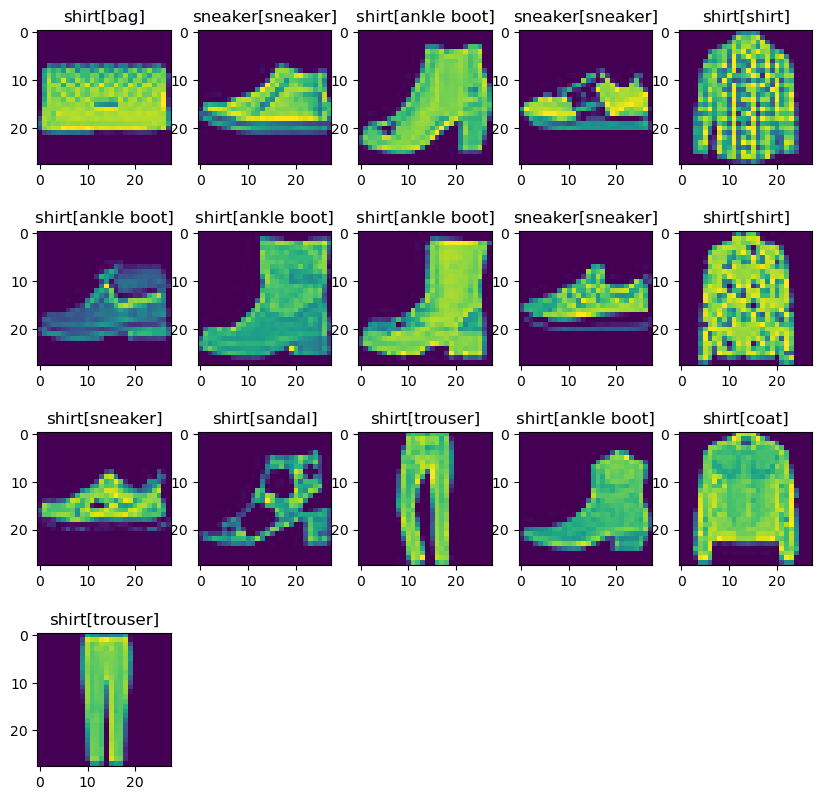

/Users/matthiaskiller/miniforge3/envs/dl-zero2one/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 3125/3125 [00:24<00:00, 125.11it/s, v_num=2]

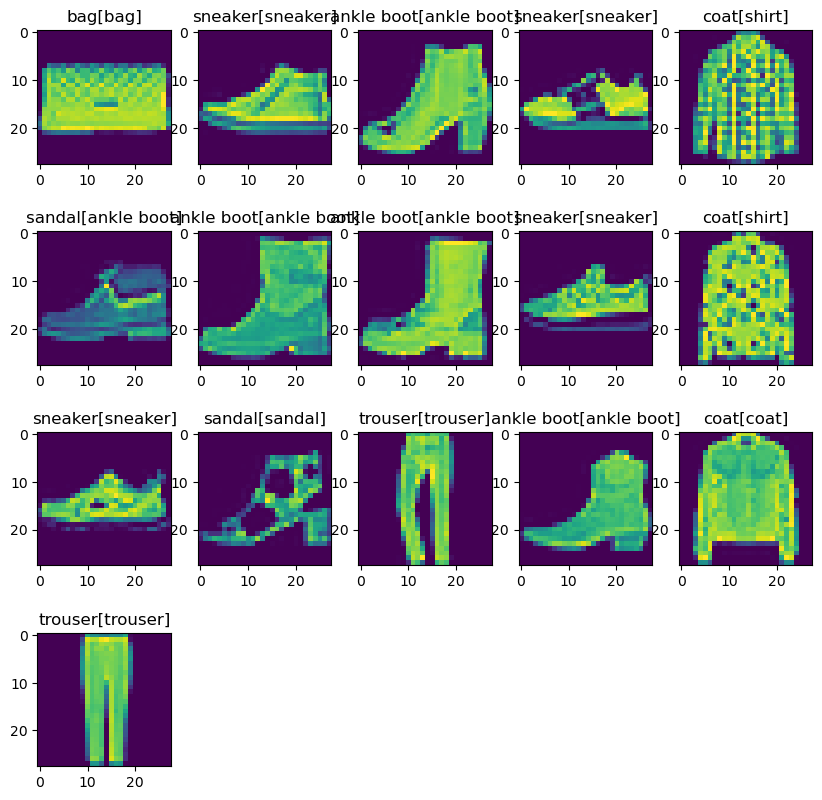

Epoch 0: 100%|██████████| 3125/3125 [00:30<00:00, 102.86it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3125/3125 [00:30<00:00, 102.84it/s, v_num=2]


In [6]:
trainer.fit(model,train_dataloaders=data.train_dataloader(),val_dataloaders=data.val_dataloader())

Checkout the directory `lightning_logs`. For each run there is a new directory `version_xx` created. The rightmost argument in the progress bar, the `v_num` variable above shows the version of the current run. Each directory automatically contains a folder with checkpoints, logs and the hyperparameters for this run.

As seen in the last notebook, you can have a look at the  logs of the runs in the TensorBoard  
Use the command as in the previous notebook in your terminal 
```
tensorboard --logdir lightning_logs
```

## 4.3 Add images to tensorboard

The tensorboard logger is a submodule of the `LightningModule` and can be accessed via `self.logger`. We can  add images  to the logging module by calling 
```python
self.logger.experiment.add_image('tag', image)
```
to add an image. 


We will log the first batch of validation images in a grid together with the predicted class labels and the ground truth labels. 

```python
        if batch_idx == 0:
            self.visualize_predictions(images, out.detach(), targets)
```

Let's have a look at the implementation of `visualize_predictions()` function in `dl_zero2one.lightning_models`.



```python
    def visualize_predictions(self, images, preds, targets):
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                       'dog', 'frog', 'horse', 'ship', 'truck']

        # determine size of the grid based on given batch size
        num_rows = torch.tensor(len(images)).float().sqrt().floor()
        
        fig = plt.figure(figsize=(10, 10))
        for i in range(len(images)):
            plt.subplot(num_rows ,len(images) // num_rows + 1, i+1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(class_names[torch.argmax(preds, axis=-1)[i]] + f'\n[{class_names[targets[i]]}]')
            plt.axis('off')

        self.logger.experiment.add_figure('predictions', fig, global_step=self.global_step)
```

You can view the logged images in your `IMAGES` tab of TensorBoard.

We have now looked at how to train a model using PyTorch Lightning. PyTorch Lightning is very active in developement and the features set are continously expanded and updated.


# 4. Other Features of PyTorch Lightning


### Checking  training timings

The argument `profiler=True` of the `Trainer` class measures the time taken in different steps such as dataloading, forward and backward pass.

Run the cell below to see for yourself.

In [7]:
from IPython.display import clear_output 

from dl_zero2one.lightning_models import TwoLayerNet
from dl_zero2one.data_class import FashionMNISTDataModule

hparams = {
    "batch_size": 16,
    "learning_rate": 1e-3,
}


model = TwoLayerNet(hparams)

data=FashionMNISTDataModule(hparams["batch_size"])
data.prepare_data()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 407 K 
-------------------------------------
407 K     Trainable params
0         Non-trainable params
407 K     Total params
1.628     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/matthiaskiller/miniforge3/envs/dl-zero2one/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


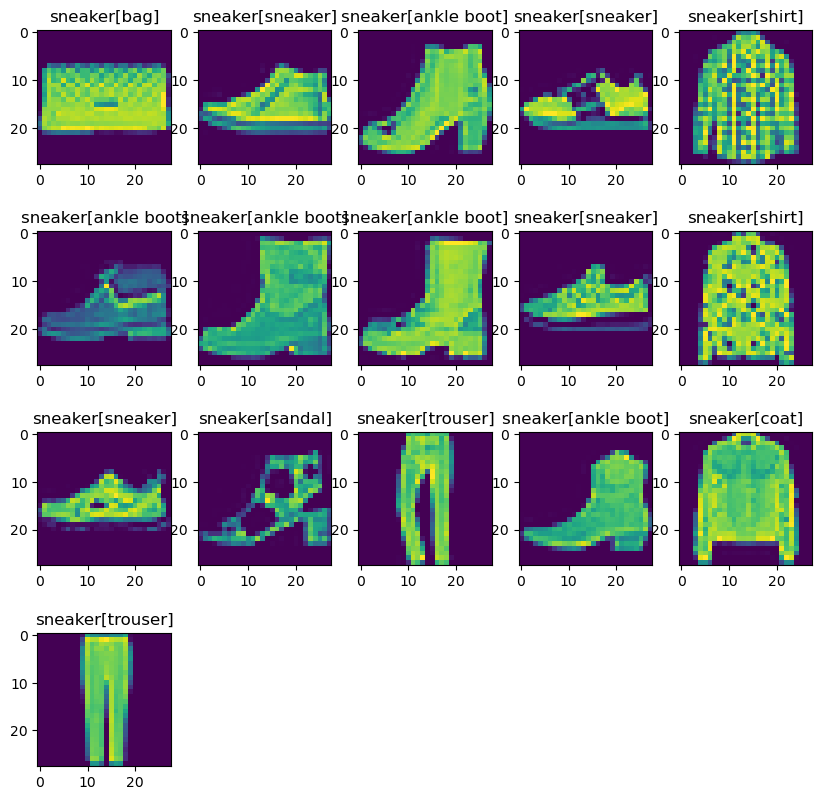

/Users/matthiaskiller/miniforge3/envs/dl-zero2one/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 3125/3125 [00:24<00:00, 129.13it/s, v_num=3]

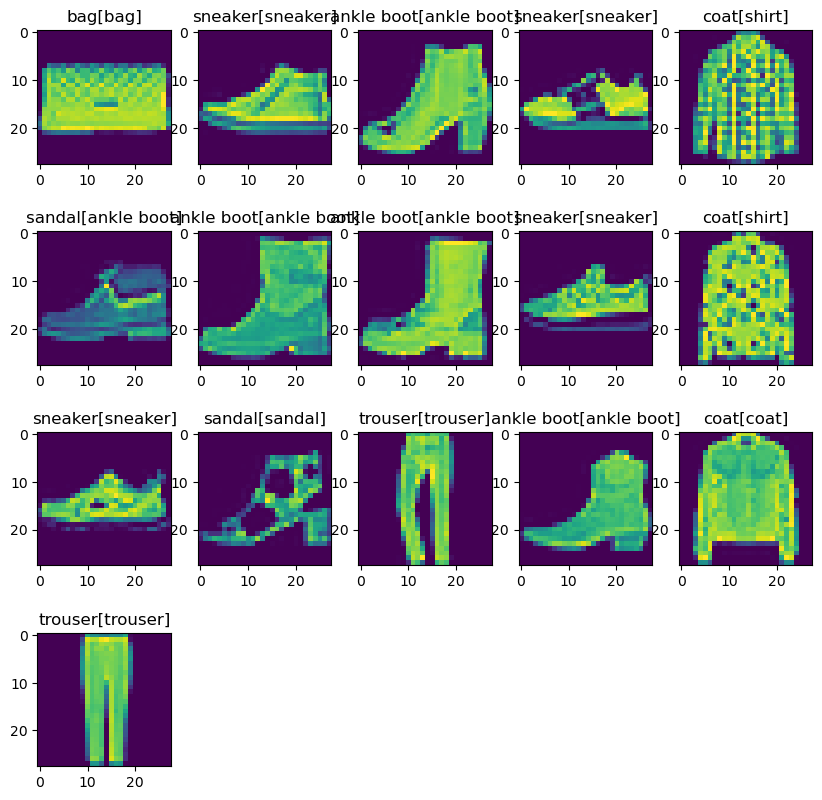

Epoch 0: 100%|██████████| 3125/3125 [00:28<00:00, 108.44it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3125/3125 [00:28<00:00, 108.42it/s, v_num=3]


FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  121365         	|

In [9]:
trainer = pl.Trainer(
    profiler="simple",
    accelerator='mps', # to use multiple also cpu, gpu or tpu possible
    max_epochs=1,
    enable_progress_bar=True, 
)

trainer.fit(model,train_dataloaders=data.train_dataloader(),val_dataloaders=data.val_dataloader())
# @num_workers=1  in data-loader --> 28.439s

We can see an overview of the time taken for different steps.
This  enables us to detect bottlenecks in the model more easily. A bottleneck can be, for example, long times in dataloading. It becomes very important later, especially, when you start to implement custom layers or loss functions.

### Some more debugging Options

* [`fast_dev_run`](https://pytorch-lightning.readthedocs.io/en/latest/trainer.html#fast-dev-run): Runs of batch of each train, validation and test pass (if validation and test datalaoders are passed as arguments).This is a fast way to check if everything works (dataloading, validation metric, model saving/ loading) without having to wait for a full epoch.

* [`track_grad_norm`](https://pytorch-lightning.readthedocs.io/en/latest/trainer.html#track-grad-norm): Logs the  norm of the gradients (set to `1` for the $L1$ norm or `2` for the $L2$ norm) for each layer. You can check whether the network is actually doing something. If the gradients are too small or too high, you won't have a good training (due to vanishing/ exploding gradients).


### Other Features

Finally, we want to mention some other useful options in the Trainer class:

* [`resume_from_checkpoint`](https://pytorch-lightning.readthedocs.io/en/latest/trainer.html#resume-from-checkpoint): Start the training from a checkpoint saved earlier. Argument is the path to the saved model file.
* [`Callbacks`](https://pytorch-lightning.readthedocs.io/en/latest/callbacks.html#callback): Callbacks are extremely useful system during training that automate non essential code such as  storing model checkpoints , saving weights values among others.

Let's have the look at the [`EarlyStopping`](https://pytorch-lightning.readthedocs.io/en/latest/early_stopping.html#early-stopping-based-on-metric-using-the-earlystopping-callback)  callback.

It interrupts the training if the `monitor` metric variable does not  improve for `patience` number of epochs.

Below is a code example on how to apply it!

```python
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   patience=3,
   verbose=False,
   mode='max'
)

trainer = Trainer(max_epochs=10,callbacks=[early_stop_callback])
```

## References

1. PyTorch Lightining [`Source Code`](https://github.com/PyTorchLightning/pytorch-lightning) with a nice introduction 
2. PyTorch Lightining [`Documentation`](https://pytorch-lightning.readthedocs.io/en/latest/#)  Explore it! The features are very well explained. 